In [55]:

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV





In [56]:

# import flight_test.csv
flight_test = pd.read_csv('flight_test.csv')
flight_test['time_hour'] = pd.to_datetime(flight_test['time_hour'], format='%m/%d/%Y %H:%M')
# import weather.csv
weather = pd.read_csv('weather.csv')
weather['time_hour'] = pd.to_datetime(weather['time_hour'], format='%Y-%m-%d %H:%M')
weather = weather.drop(['Unnamed: 0'], axis=1)
# import flight_train.csv
flight_train = pd.read_csv('flight_train.csv')
flight_train['time_hour'] = pd.to_datetime(flight_train['time_hour'], format='%Y-%m-%d %H:%M')

flight_train = flight_train.drop(['Unnamed: 0'], axis=1)

In [57]:
flight_train.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,10,15,1627.0,1450,97.0,1845.0,1745,60.0,UA,370,N491UA,EWR,MCO,119.0,937,14,50,2013-10-15 14:00:00
1,2013,4,27,1556.0,1559,-3.0,1815.0,1835,-20.0,DL,847,N670DN,LGA,ATL,110.0,762,15,59,2013-04-27 15:00:00
2,2013,12,8,719.0,650,29.0,958.0,912,46.0,UA,245,N570UA,EWR,DEN,246.0,1605,6,50,2013-12-08 06:00:00
3,2013,4,16,454.0,500,-6.0,625.0,640,-15.0,US,1219,N189UW,EWR,CLT,76.0,529,5,0,2013-04-16 05:00:00
4,2013,6,28,808.0,740,28.0,959.0,941,18.0,EV,4104,N13964,EWR,CHS,93.0,628,7,40,2013-06-28 07:00:00


In [34]:
flight_test.head()

,year,month,day,sched_dep_time,sched_arr_time,carrier,flight,tailnum,origin,dest,distance,hour,minute,time_hour
0,2013,7,7,1520,1705,AA,2223,N526AA,LGA,STL,888,15,20,2013-07-07 15:00:00
1,2013,1,29,1455,1825,AA,1769,N5EVAA,JFK,MIA,1089,14,55,2013-01-29 14:00:00
2,2013,2,17,1245,1550,AA,745,N3JCAA,LGA,DFW,1389,12,45,2013-02-17 12:00:00
3,2013,4,2,1659,1821,EV,4562,N19554,EWR,RIC,277,16,59,2013-04-02 16:00:00
4,2013,11,26,1455,1650,MQ,3391,N818MQ,LGA,CMH,479,14,55,2013-11-26 14:00:00


In [35]:
weather.head()

,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,1,39.02,26.06,59.37,270.0,10.35702,NaN,0.0,1012.0,10.0,2013-01-01 01:00:00
1,EWR,2013,1,1,2,39.02,26.96,61.63,250.0,8.05546,NaN,0.0,1012.3,10.0,2013-01-01 02:00:00
2,EWR,2013,1,1,3,39.02,28.04,64.43,240.0,11.50780,NaN,0.0,1012.5,10.0,2013-01-01 03:00:00
3,EWR,2013,1,1,4,39.92,28.04,62.21,250.0,12.65858,NaN,0.0,1012.2,10.0,2013-01-01 04:00:00
4,EWR,2013,1,1,5,39.02,28.04,64.43,260.0,12.65858,NaN,0.0,1011.9,10.0,2013-01-01 05:00:00


In [58]:
# getting the different columns
diff = []
difftest = []
for col in flight_test.columns:
    if col not in weather.columns:
        difftest.append(col)
for col in flight_train.columns:
    if col not in weather.columns:
        diff.append(col)

diff.append("time_hour")
difftest.append("time_hour")
diff.append("origin")
difftest.append("origin")



In [59]:
# combine flight_train and weather by time_hour
Weather_flight_train = flight_train[diff].set_index(['time_hour','origin']).join(weather.set_index(['time_hour','origin']), how='inner').reset_index()
Weather_flight_train = Weather_flight_train.fillna(0)

Weather_flight_test  = flight_test[difftest].set_index(['time_hour','origin']).join(weather.set_index(['time_hour','origin']), how='inner').reset_index()
Weather_flight_test = Weather_flight_test.fillna(0)

In [60]:
# no delay : 0 
# short delay : 1 (1 to 60 minutes)
# lond delay : 2 ( over 60 minutes)

delfunc  = lambda x: 0 if x <= 0 else 1 if x <= 60 else 2

Weather_flight_train["dep_delay_class"] = Weather_flight_train["dep_delay"].apply(delfunc)

Weather_flight_train["arr_delay_class"] = Weather_flight_train["arr_delay"].apply(delfunc)


array([[<AxesSubplot:title={'center':'time_hour'}>,
        <AxesSubplot:title={'center':'dep_time'}>,
        <AxesSubplot:title={'center':'sched_dep_time'}>,
        <AxesSubplot:title={'center':'dep_delay'}>,
        <AxesSubplot:title={'center':'arr_time'}>],
       [<AxesSubplot:title={'center':'sched_arr_time'}>,
        <AxesSubplot:title={'center':'arr_delay'}>,
        <AxesSubplot:title={'center':'flight'}>,
        <AxesSubplot:title={'center':'air_time'}>,
        <AxesSubplot:title={'center':'distance'}>],
       [<AxesSubplot:title={'center':'minute'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'hour'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'dewp'}>,
        <AxesSubplot:title={'center':'humid'}>,
        <AxesSubplot:title={'center':'wind_dir'}>,
        <AxesSubplot:title={'center':'wind_s

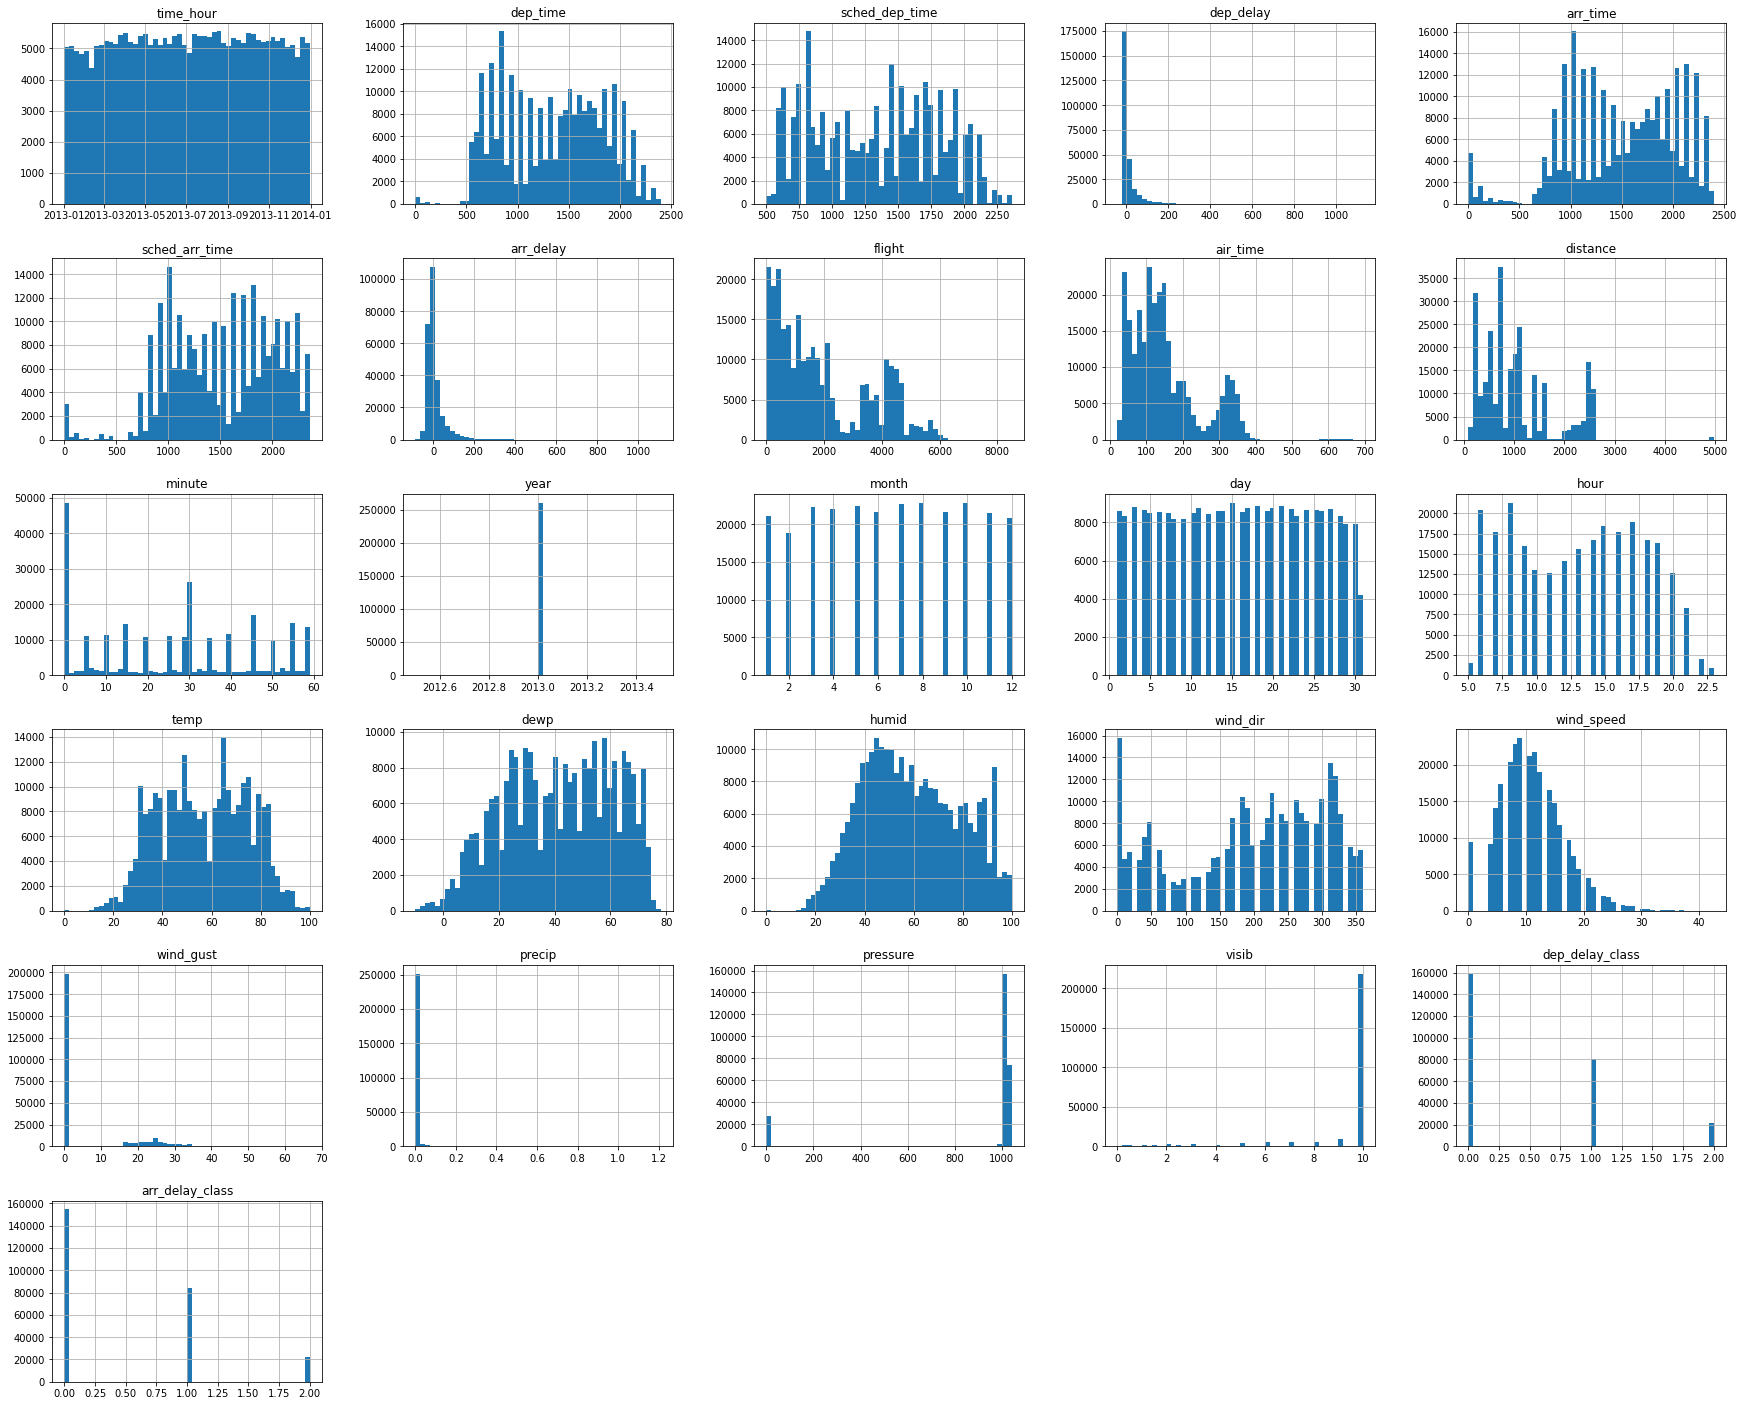

In [61]:
Weather_flight_train.hist(bins=50, figsize=(30,25))



In [62]:
import math
num_cols = list(Weather_flight_train._get_numeric_data().columns[:-2])
num_cols.remove("dep_delay")
num_cols.remove("arr_delay")
num_cols.remove("air_time")
num_cols.remove("arr_time")
num_cols.remove("dep_time") # These Variables do not appear in the flight_test.csv
num_cols.remove("wind_gust")
num_cols.remove("wind_speed")
num_cols.remove("dewp")
num_cols.remove("temp")
num_cols.remove("sched_arr_time")
num_cols.remove("year") # These Variables show high correlation each other


cols = 3
rows = math.ceil(len(num_cols)/cols)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(100,100))

col = 0
row = 0
for feat in num_cols:
    if col > 2:
        row += 1
        col = 0
    axes = ax[row,col]
    sns.boxplot(x = Weather_flight_train['dep_delay_class'], y = Weather_flight_train[feat],ax = axes)
    col += 1
plt.tight_layout()
plt.title("Individual Features by Class")
plt.fontsize = 20
plt.show()
    
Weather_flight_train = Weather_flight_train[num_cols+['dep_delay_class']]

<AxesSubplot:>

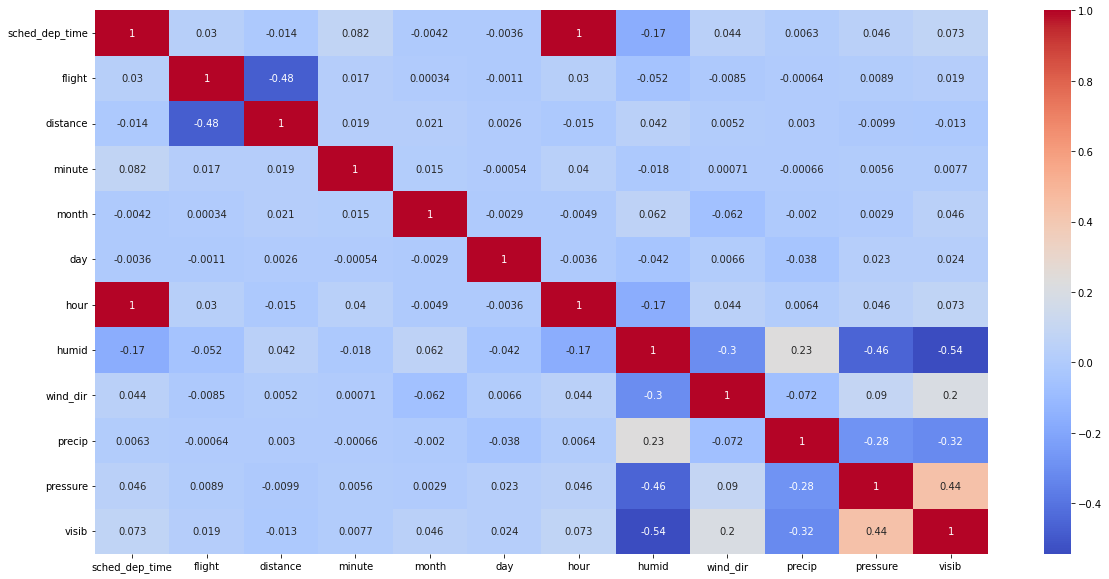

In [63]:
plt.figure(figsize=(20,10))

sns.heatmap(Weather_flight_train[num_cols].corr(), annot=True, cmap='coolwarm')

In [64]:
num_cols

['sched_dep_time',
 'flight',
 'distance',
 'minute',
 'month',
 'day',
 'hour',
 'humid',
 'wind_dir',
 'precip',
 'pressure',
 'visib']

In [ ]:
# sns.set_style('whitegrid')
# sns.pairplot(data= Weather_flight_train, hue='dep_delay_class', vars=num_cols , diag_kind="kde")
# sns.set(font_scale=1.1)

In [65]:
traincols = list(Weather_flight_train.columns)
traincols.remove("dep_delay_class")
traincols

['sched_dep_time',
 'flight',
 'distance',
 'minute',
 'month',
 'day',
 'hour',
 'humid',
 'wind_dir',
 'precip',
 'pressure',
 'visib']

In [66]:
#preprocessing


X_train, X_test, y_train, y_test = train_test_split( Weather_flight_train[traincols], Weather_flight_train['dep_delay_class'],random_state=80,test_size=0.25)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaler.fit(X_test)
Scaled_X_test = scaler.fit_transform(X_test)


In [67]:
# Cross validation

cv = KFold(n_splits=5,shuffle=True, random_state=96)


In [68]:
# first model


LogReg = LogisticRegression( max_iter=3000, solver='lbfgs', multi_class='multinomial', n_jobs=-1)

cross = cross_val_score(LogReg, scaled_X_train, y_train, cv=cv, scoring='accuracy')

print ("Cross Validation Average Accuracy: ", cross.mean())
print ("Cross Validation Standard Deviation: ", cross.std())

LogReg.fit(scaled_X_train, y_train) 

predictions = LogReg.predict(Scaled_X_test)

acc = metrics.accuracy_score(y_test, predictions)

print ("Accuracy: ", acc)

print(metrics.classification_report(y_test, predictions))


Cross Validation Average Accuracy:  0.6146345721880371
Cross Validation Standard Deviation:  0.003332094548835512
Accuracy:  0.6115160909132763
              precision    recall  f1-score   support

           0       0.63      0.94      0.76     39522
           1       0.44      0.12      0.19     20477
           2       0.37      0.02      0.04      5162

    accuracy                           0.61     65161
   macro avg       0.48      0.36      0.33     65161
weighted avg       0.55      0.61      0.52     65161



In [75]:
Weather_flight_pred = scaler.fit_transform(Weather_flight_test[num_cols])


predictions = LogReg.predict(Weather_flight_pred)
predictions = pd.DataFrame(predictions)
predictions.columns = ['dep_delay_class']
Weather_flight_test['dep_delay_class'] = predictions

Weather_flight_test.to_csv('Weather_flight_test.csv')

In [76]:
Weather_flight_test['dep_delay_class'].value_counts()

0    59241
1     5602
2      333
Name: dep_delay_class, dtype: int64

<AxesSubplot:>

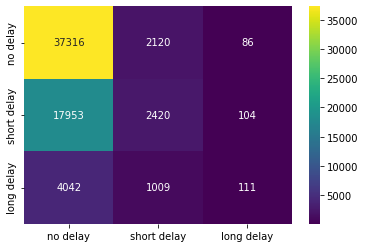

In [69]:

conf = metrics.confusion_matrix(y_test, predictions)
conf_df = pd.DataFrame(conf, index=['no delay', 'short delay', 'long delay'], columns=['no delay', 'short delay', 'long delay'])

sns.heatmap(conf_df, annot=True, fmt='d', cmap='viridis')

In [70]:
# second Model

LDA = LinearDiscriminantAnalysis(solver= 'eigen', shrinkage= 'auto', n_components=2) 

cross = cross_val_score(LDA, scaled_X_train, y_train, cv=cv, scoring='accuracy')
print ("Cross Validation Average Accuracy: ", cross.mean())
print ("Cross Validation Standard Deviation: ", cross.std())


dataplot = LDA.fit(scaled_X_train, y_train)
predictions = dataplot.predict(Scaled_X_test)



acc = metrics.accuracy_score(y_test, predictions)

print ("Accuracy: ", acc)

print(metrics.classification_report(y_test, predictions))


Cross Validation Average Accuracy:  0.6145680735388378
Cross Validation Standard Deviation:  0.003615457041505048
Accuracy:  0.6100581636254815
              precision    recall  f1-score   support

           0       0.63      0.94      0.75     39522
           1       0.44      0.12      0.18     20477
           2       0.35      0.06      0.10      5162

    accuracy                           0.61     65161
   macro avg       0.47      0.37      0.35     65161
weighted avg       0.55      0.61      0.52     65161



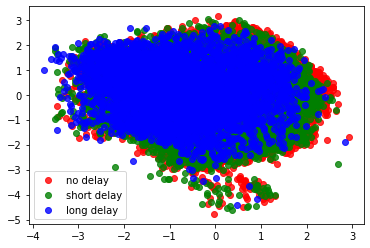

In [78]:
data_plot = dataplot.transform(Scaled_X_test)
target_names = ['no delay', 'short delay', 'long delay']

#create LDA plot
plt.figure()
colors = ['red', 'green', 'blue']
lw = 2
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(data_plot[y_test == i, 0], data_plot[y_test == i, 1], alpha=.8, color=color,
                label=target_name)

#add legend to plot
plt.legend(loc='best', shadow=False, scatterpoints=1)

#display LDA plot
plt.show()

<AxesSubplot:>

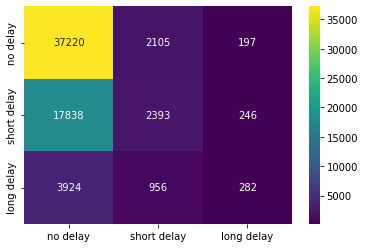

In [63]:

conf = metrics.confusion_matrix(y_test, predictions)
conf_df = pd.DataFrame(conf, index=['no delay', 'short delay', 'long delay'], columns=['no delay', 'short delay', 'long delay'])

sns.heatmap(conf_df, annot=True, fmt='d', cmap='viridis')

In [71]:
# third Model 

QDA = QuadraticDiscriminantAnalysis(  reg_param=0.05, store_covariance=True, tol=.07)

cross = cross_val_score(QDA, scaled_X_train, y_train, cv=cv, scoring='accuracy')
print ("Cross Validation Average Accuracy: ", cross.mean())
print ("Cross Validation Standard Deviation: ", cross.std())


dataplot = QDA.fit(scaled_X_train, y_train)


predictions = dataplot.predict(Scaled_X_test)

acc = metrics.accuracy_score(y_test, predictions)

print ("Accuracy: ", acc)
print(metrics.classification_report(y_test, predictions))

C:\Users\huramabi.nziayotchou\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\huramabi.nziayotchou\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\huramabi.nziayotchou\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\huramabi.nziayotchou\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\huramabi.nziayotchou\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.wa

Cross Validation Average Accuracy:  0.6045569123515857
Cross Validation Standard Deviation:  0.0031583412895948297
Accuracy:  0.5988397968109759
              precision    recall  f1-score   support

           0       0.63      0.92      0.75     39522
           1       0.42      0.09      0.14     20477
           2       0.24      0.16      0.19      5162

    accuracy                           0.60     65161
   macro avg       0.43      0.39      0.36     65161
weighted avg       0.53      0.60      0.52     65161



C:\Users\huramabi.nziayotchou\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


<AxesSubplot:>

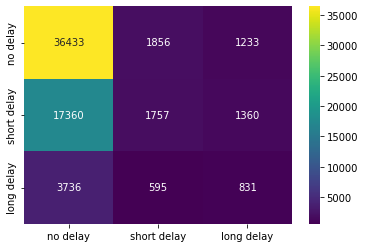

In [72]:

conf = metrics.confusion_matrix(y_test, predictions)
conf_df = pd.DataFrame(conf, index=['no delay', 'short delay', 'long delay'], columns=['no delay', 'short delay', 'long delay'])

sns.heatmap(conf_df, annot=True, fmt='d', cmap='viridis')

In [73]:
# # fourth Model

kn = KNeighborsClassifier( weights='distance',algorithm="kd_tree")

cross = cross_val_score(kn, scaled_X_train, y_train, cv=cv, scoring='accuracy')
print ("Cross Validation Average Accuracy: ", cross.mean())
print ("Cross Validation Standard Deviation: ", cross.std())


kn.fit(scaled_X_train, y_train)

predictions = kn.predict(Scaled_X_test)

acc = metrics.accuracy_score(y_test, predictions)

print ("Accuracy: ", acc)

print(metrics.classification_report(y_test, predictions))

Cross Validation Average Accuracy:  0.5977072042237489
Cross Validation Standard Deviation:  0.0017738709972683795
Accuracy:  0.597489295744387
              precision    recall  f1-score   support

           0       0.68      0.79      0.73     39522
           1       0.42      0.33      0.37     20477
           2       0.36      0.20      0.26      5162

    accuracy                           0.60     65161
   macro avg       0.48      0.44      0.45     65161
weighted avg       0.57      0.60      0.58     65161



<AxesSubplot:>

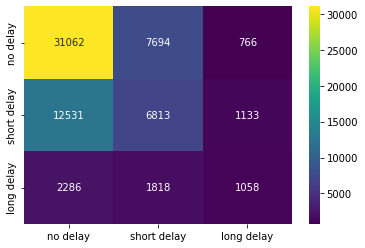

In [74]:
conf = metrics.confusion_matrix(y_test, predictions)
conf_df = pd.DataFrame(conf, index=['no delay', 'short delay', 'long delay'], columns=['no delay', 'short delay', 'long delay'])

sns.heatmap(conf_df, annot=True, fmt='d', cmap='viridis')